In [227]:
#% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
import healpy as hp
from astropy.io.votable import parse_single_table
import matplotlib.cm as cm
from scipy.stats import median_abs_deviation as mad

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

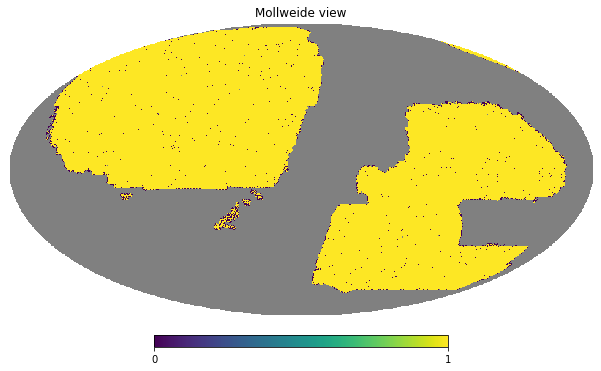

In [228]:
# Read both data sets and the full coverage mask

wholesouthdata = pd.read_csv('../../bricks_data/uncleaned_systematics_south.csv')

northdata = pd.read_csv('../../bricks_data/uncleaned_systematics_north.csv')

fullmask = hp.read_map("../../bricks_data/masks/mask_512.fits")
fullmask = fullmask[hp.ring2nest(512, np.arange(hp.nside2npix(512)))]
hp.mollview(fullmask, rot=110)


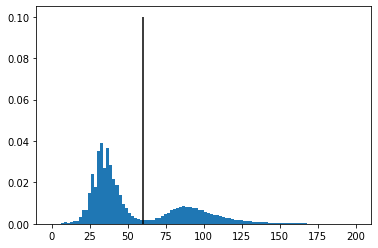

In [229]:
# for the south we can split DES & DECALS based on number of exposures

plt.hist(wholesouthdata['exposures'], range=[0, 200], bins=100, density=True)
plt.vlines(60, 0, .1, color='k')

# create arrays holding coordinates of healpix pixels
# both longitude-latitude and galactic coordinates, in order to make further cuts.
lon, lat = hp.pix2ang(512, np.arange(hp.nside2npix(512)), lonlat=True, nest=False)
theta, phi = hp.pix2ang(512, np.arange(hp.nside2npix(512)), lonlat=False, nest=False)
rot = hp.Rotator(coord=['E', 'G'])
l, b = rot(theta, phi)

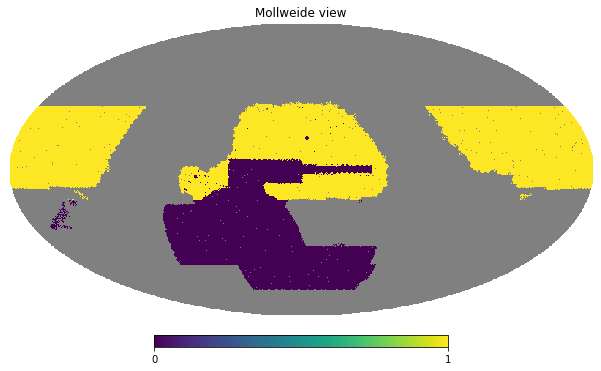

In [230]:
# main cuts for south
southipixmask = np.logical_or(
    wholesouthdata['exposures'] < 60,
    l[wholesouthdata['pixel_id']] < np.pi / 2
)
southipixmask &= lat[wholesouthdata['pixel_id']] > -15


# apply coverage mask, just in case.
southipixmask &= fullmask[wholesouthdata['pixel_id']]

hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN
hpmap[wholesouthdata['pixel_id'][southipixmask]] = 1
hpmap[wholesouthdata['pixel_id'][~southipixmask]] = 0

hp.mollview(hpmap)

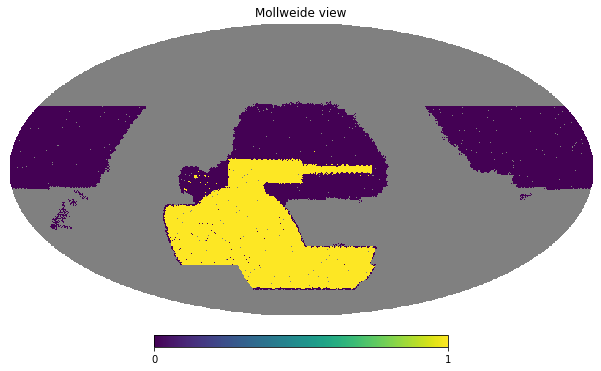

In [231]:
# main cuts for DES
desipixmask = wholesouthdata['exposures'] > 60
desipixmask &= lat[wholesouthdata['pixel_id']] < 10
desipixmask &= l[wholesouthdata['pixel_id']] > np.pi / 2

# apply coverage mask, just in case.
hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN
hpmap[wholesouthdata['pixel_id'][desipixmask]] = 1
hpmap[wholesouthdata['pixel_id'][~desipixmask]] = 0

hp.mollview(hpmap)

In [232]:
# Now create arrays holding the three data sets

desdata = wholesouthdata[desipixmask]
southdata = wholesouthdata[southipixmask]
northdata = northdata[fullmask[northdata['pixel_id']] > 0]


In [233]:
# Select one of them! for running the rest of the code below
# (a hacky way to make a choice...)

data = northdata

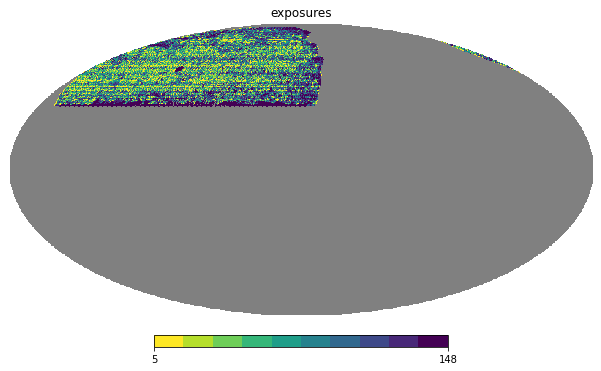

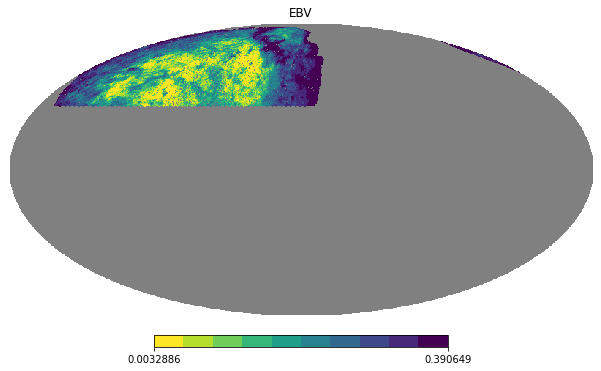

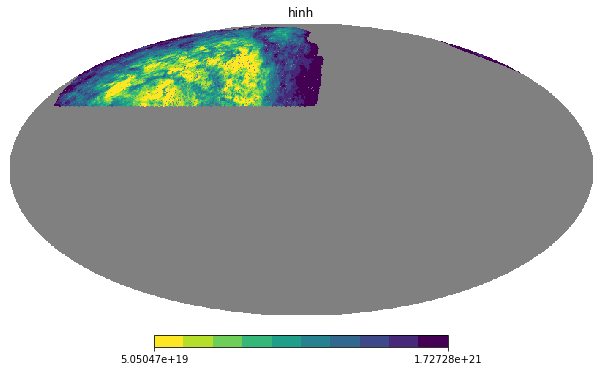

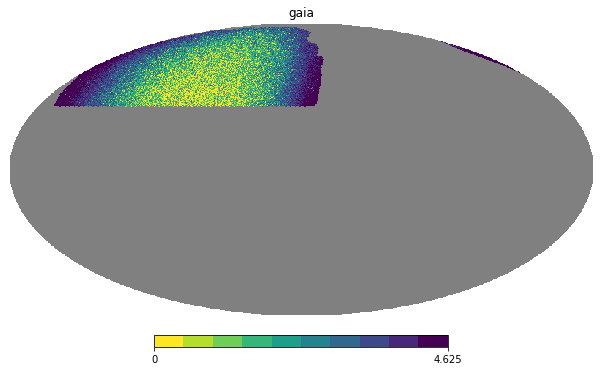

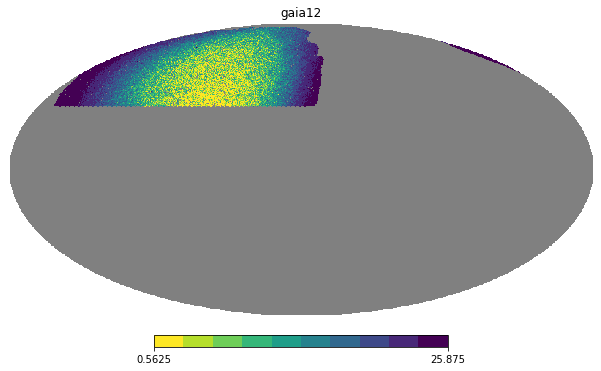

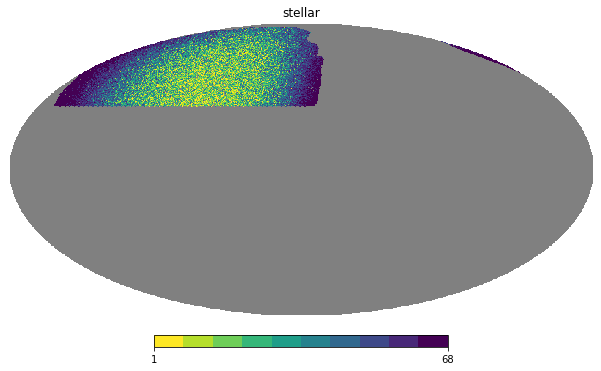

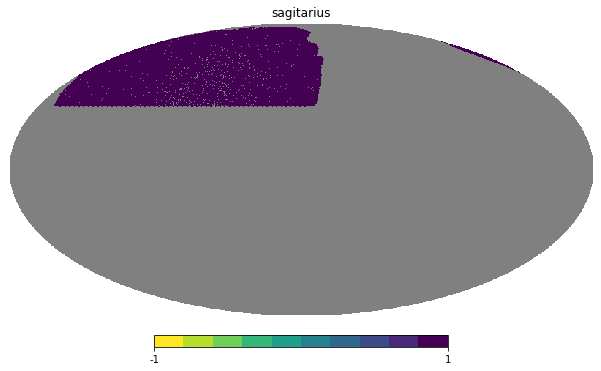

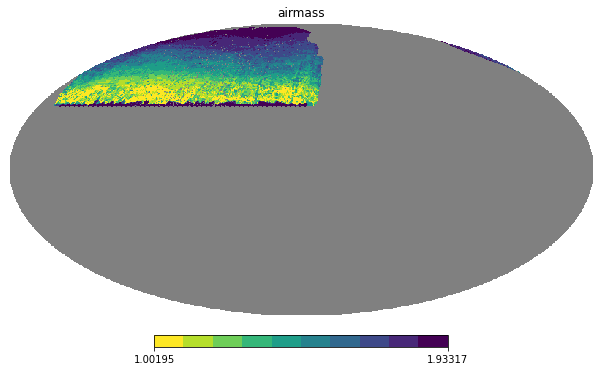

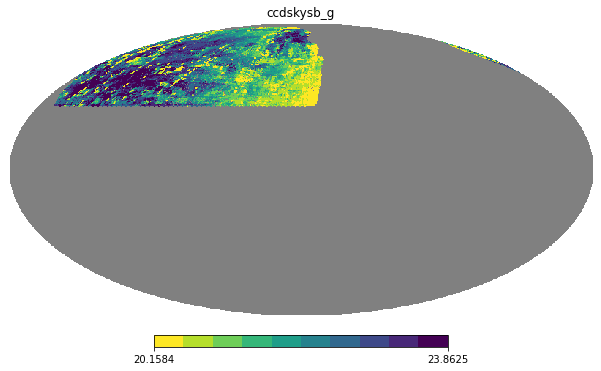

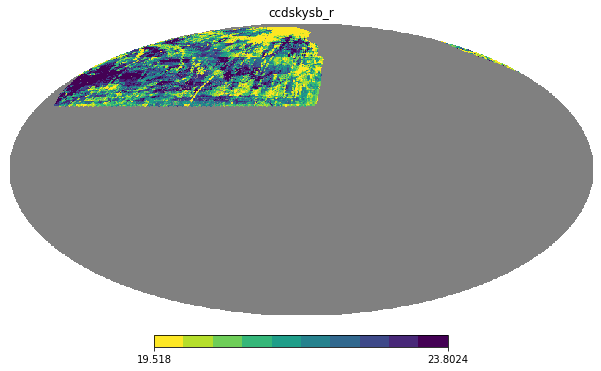

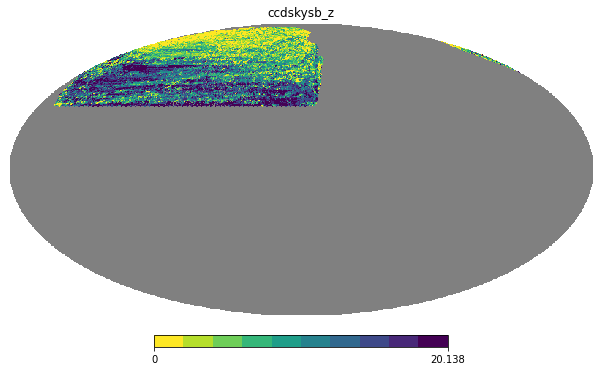

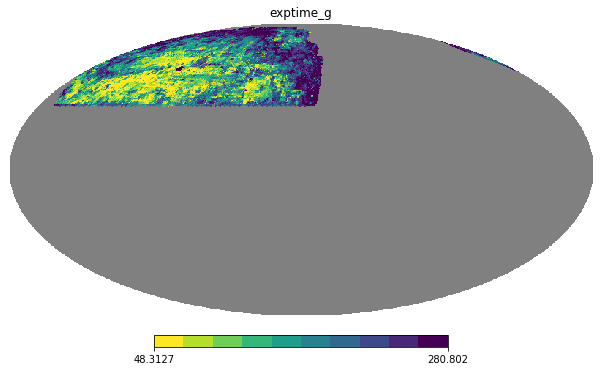

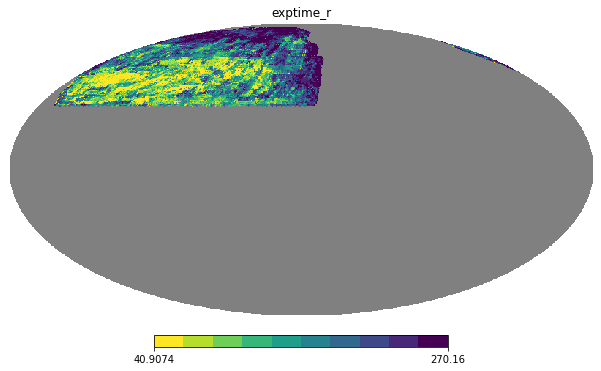

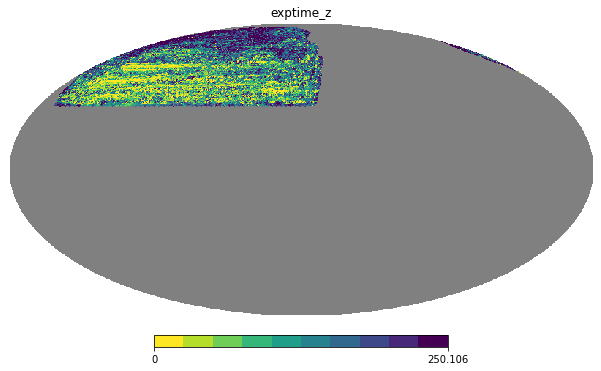

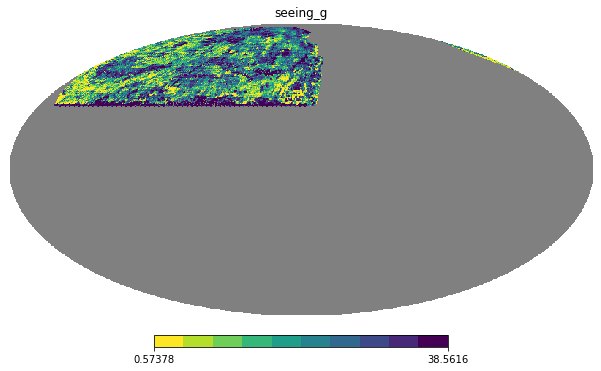

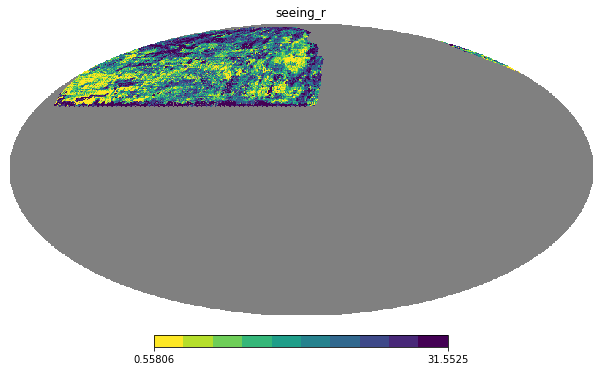

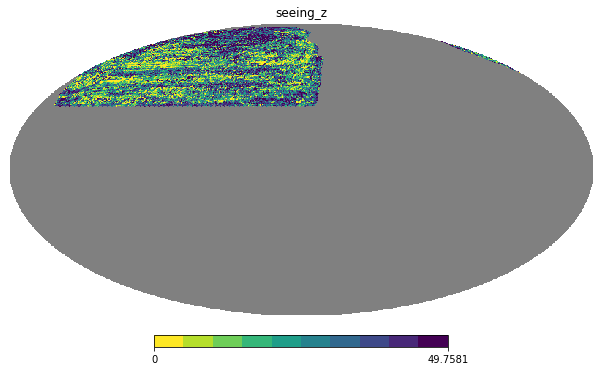

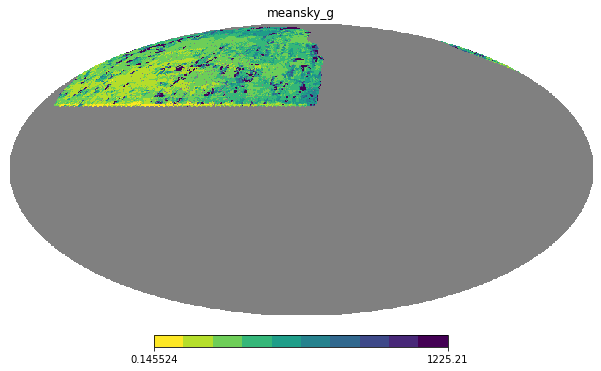

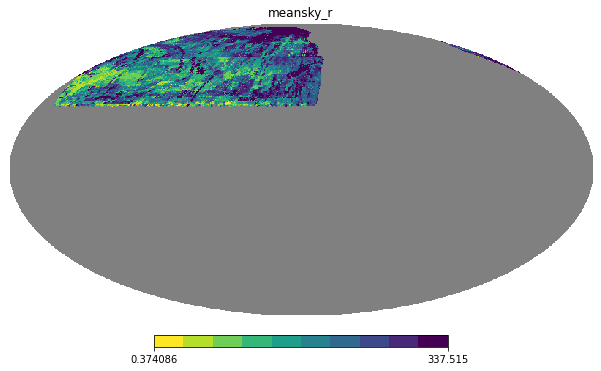

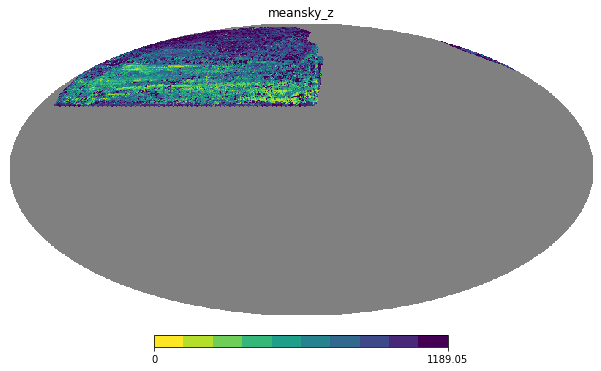

In [234]:
# simply plot all maps

names = [
    'exposures',
    'EBV',
    'hinh', 'gaia', 'gaia12', 'stellar', 'sagitarius', 'airmass',
    'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z',
    'exptime_g', 'exptime_r', 'exptime_z',
    'seeing_g', 'seeing_r', 'seeing_z',
    'meansky_g', 'meansky_r', 'meansky_z'
]

for i, nm in enumerate(names):
    hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN
    hpmap[data['pixel_id']] = data[nm]
    hp.mollview(hpmap, hold=False, cmap=cm.get_cmap('viridis_r', 10), norm='hist', rot=110, title=nm)

In [235]:
# which ones to make mask cuts on?

names = [
    #'exposures',
    'EBV',
    'hinh', 'gaia', 'gaia12', 'stellar', 'airmass',
    'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z',
    'exptime_g', 'exptime_r', 'exptime_z',
    'seeing_g', 'seeing_r', 'seeing_z',
    'meansky_g', 'meansky_r', 'meansky_z']

In [236]:
# number of standard deviations away from mean
x = 10

Systematic EBV 862
Systematic hinh 279
Systematic gaia 60
Systematic gaia12 2276
Systematic stellar 752
Systematic airmass 0
Systematic ccdskysb_g 650
Systematic ccdskysb_r 13
Systematic ccdskysb_z 3
Systematic exptime_g 0
Systematic exptime_r 0
Systematic exptime_z 0
Systematic seeing_g 467
Systematic seeing_r 431
Systematic seeing_z 580
Systematic meansky_g 9480
Systematic meansky_r 9360
Systematic meansky_z 8987


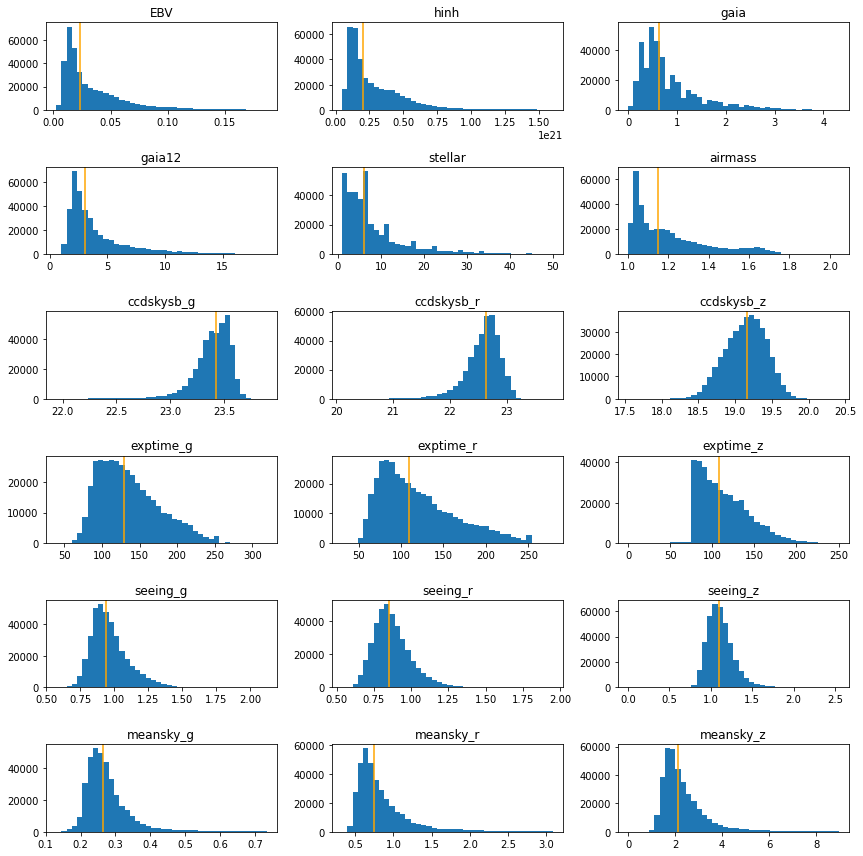

In [237]:
# now plot histograms of the pixel values in each map AFTER the median+-stdev cut.
ipix = data['pixel_id']
fig, axs = plt.subplots(6, 3, figsize=(12, 12))
axs = axs.ravel()
hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN


for i, nm in enumerate(names):
    themin, themax = np.min(data[nm]), np.max(data[nm])
    ind = np.isfinite(data[nm])
    themean, thestd = np.median(data[nm][ind]), mad(data[nm][ind], scale='normal')
    themin2 = themean - x * thestd
    themax2 = themean + x * thestd
    ind &= data[nm] < themax2
    ind &= data[nm] > themin2

    print('Systematic', nm, np.sum(~ind))
    hpmap[ipix[~ind]] = 1
    hpmap[ipix[hpmap[ipix] == hp.UNSEEN]] = 0

    axs[i].hist(data[nm][ind], log=False, bins=40)
    axs[i].axvline(themean, c='orange')
    axs[i].set_title(nm)
fig.tight_layout()

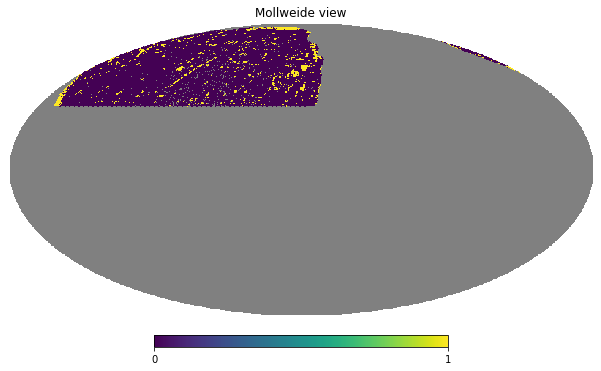

In [238]:
# plot the resulting total mask.
hp.mollview(hpmap, rot=110, cmap='viridis')

In [239]:
unique = np.arange((hp.nside2npix(512)))

id_density = np.stack((unique, hpmap), axis=1)

df = pd.DataFrame(id_density, columns=['pixel_id', 'hpmap'])
df.pixel_id = df.pixel_id.astype(int)

print(len(df))
df.head()
print(len(southdata))

print((hpmap == 1.0).sum())

3145728
701238
29716


In [240]:
print(len(df), len(data))
df_final = pd.merge(data, df, how='inner', on='pixel_id')
#df.drop(columns='coverage')
print(df_final.hpmap.unique())
df_final = df_final[df_final.hpmap == 0.0]


3145728 378636
[1. 0.]


In [241]:
print(len(df_final))

348920


In [242]:
scaler = MinMaxScaler()

In [243]:
cols = ['exposures', 'hinh',
        'gaia', 'gaia12', 'sagitarius', 'stellar', 'EBV',
        'airmass', 'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z', 'exptime_g',
        'exptime_r', 'exptime_z', 'meansky_g', 'meansky_r', 'meansky_z', 'seeing_g', 'seeing_r',
        'seeing_z']
print(df_final.columns)

Index(['pixel_id', 'lrg', 'elg', 'qso', 'glbg', 'rlbg', 'exposures', 'hinh',
       'gaia', 'gaia12', 'sagitarius', 'stellar', 'EBV', 'airmass',
       'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z', 'exptime_g', 'exptime_r',
       'exptime_z', 'meansky_g', 'meansky_r', 'meansky_z', 'seeing_g',
       'seeing_r', 'seeing_z', 'hpmap'],
      dtype='object')


In [244]:
df_final[cols] = scaler.fit_transform(df_final[cols])

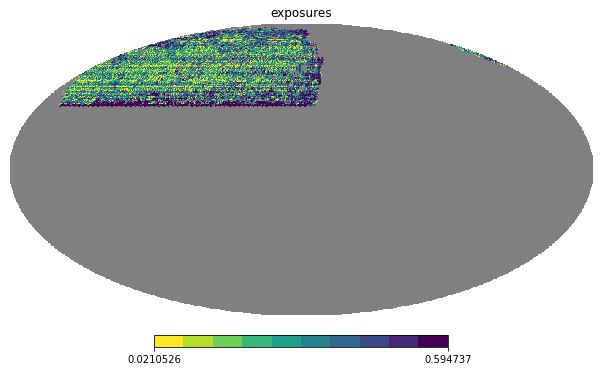

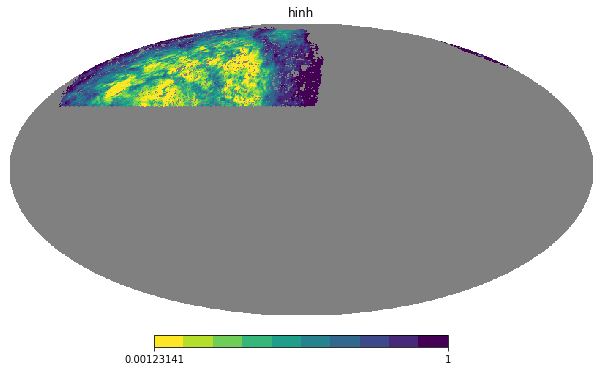

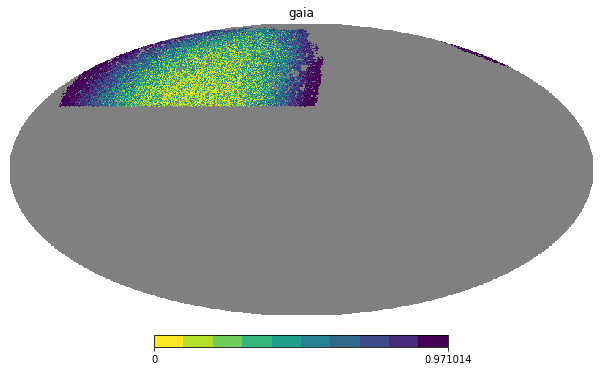

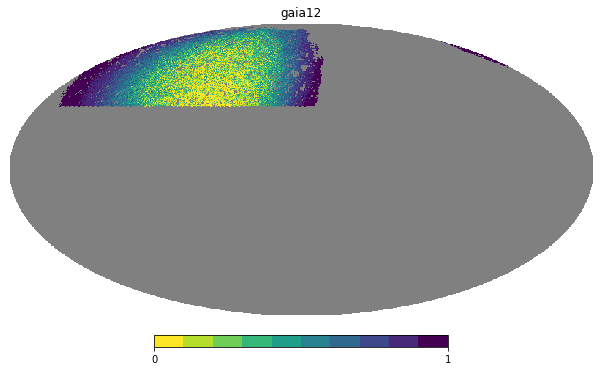

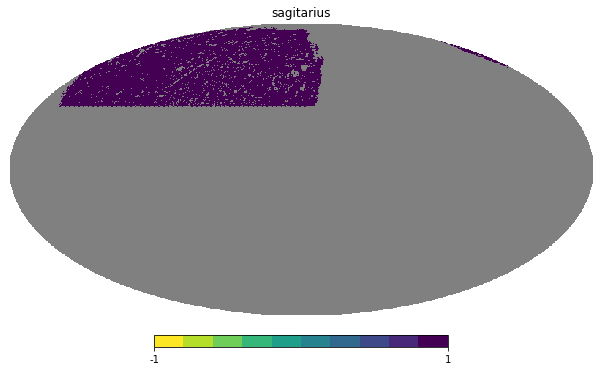

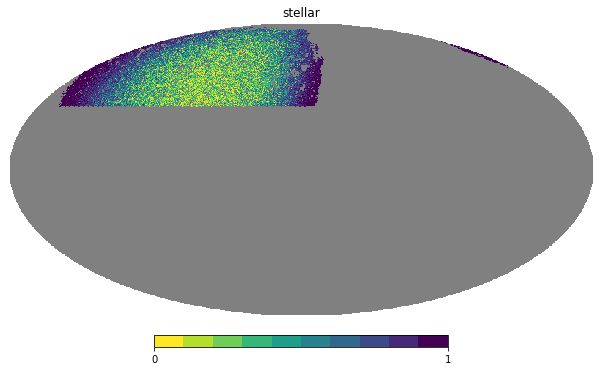

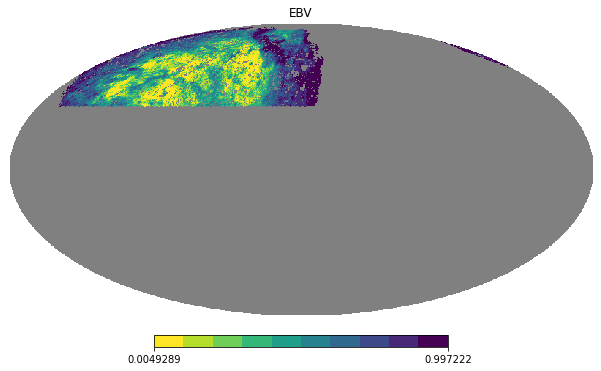

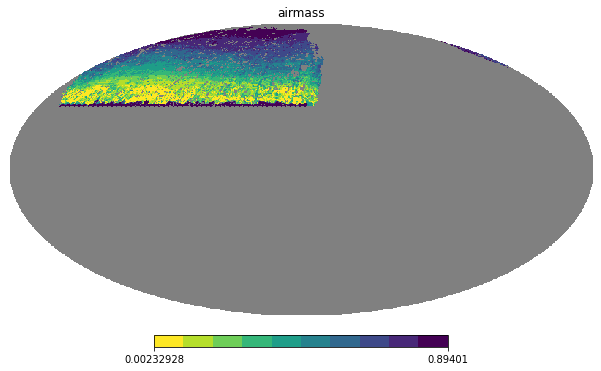

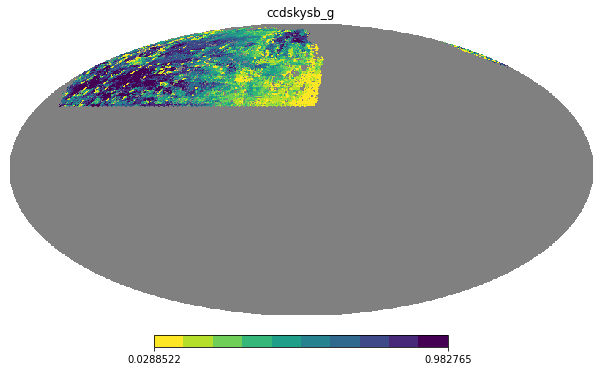

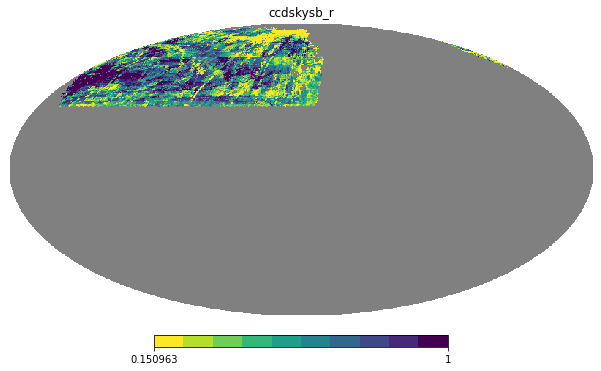

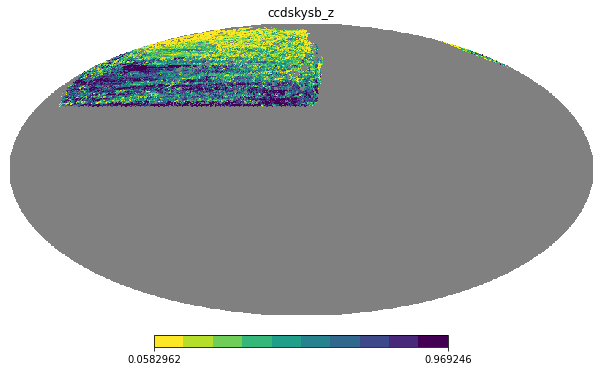

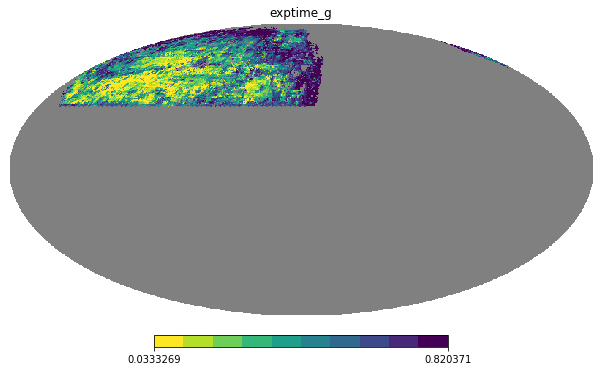

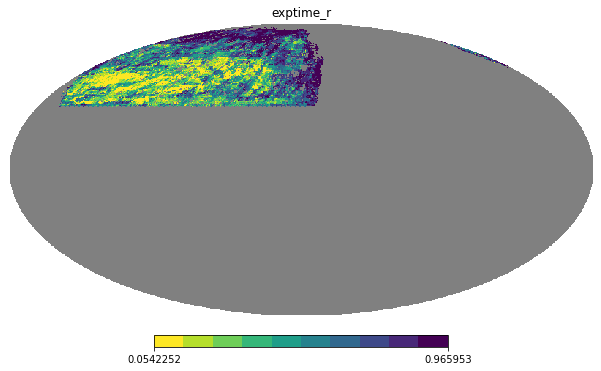

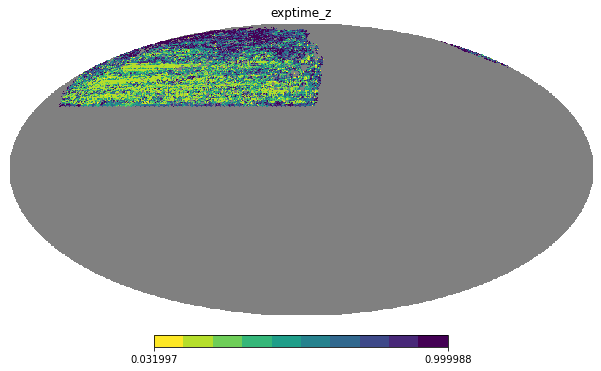

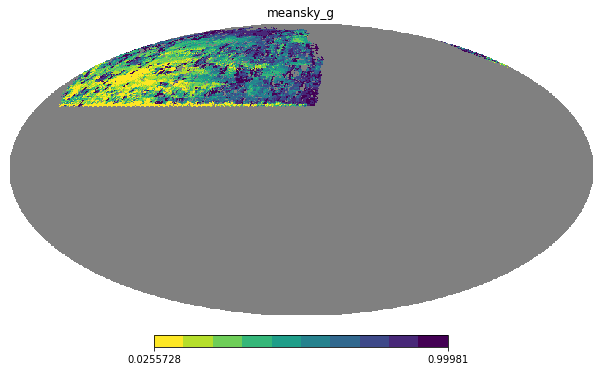

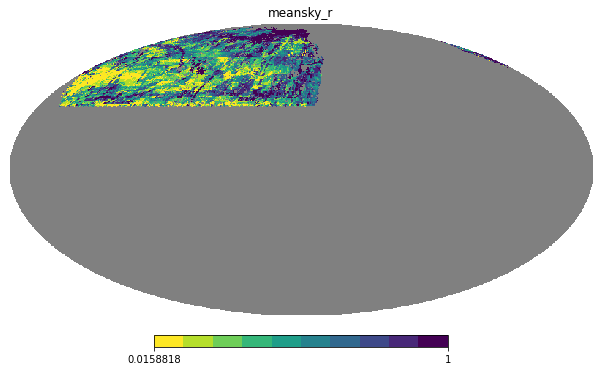

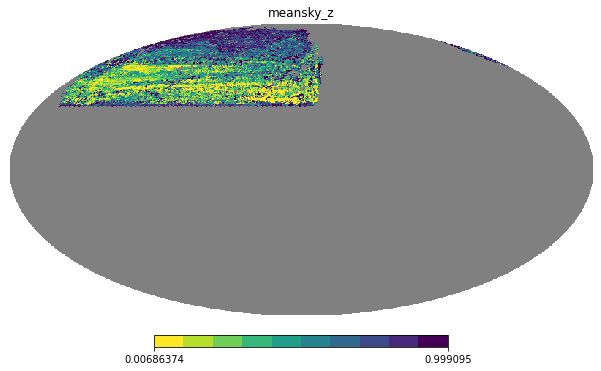

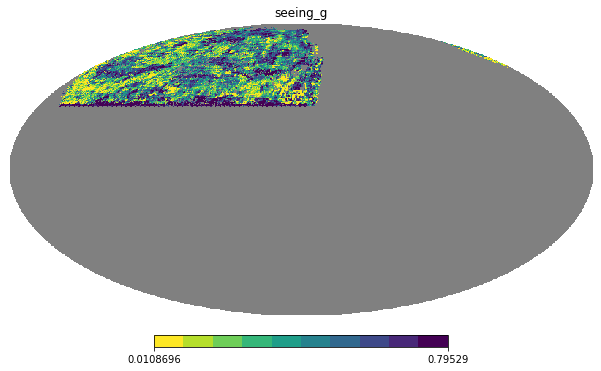

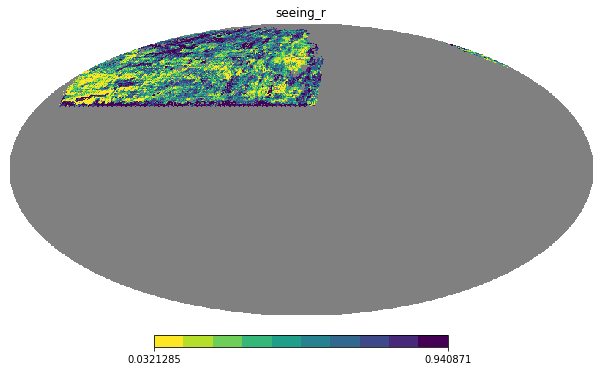

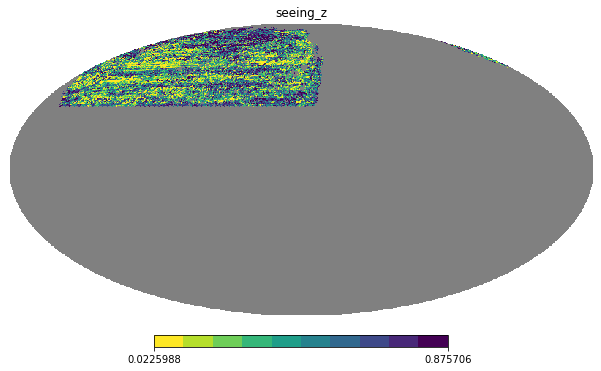

In [245]:
for i, nm in enumerate(cols):
    hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN
    hpmap[df_final['pixel_id']] = df_final[nm]
    hp.mollview(hpmap, hold=False, cmap=cm.get_cmap('viridis_r', 10), norm='hist', rot=110, title=nm)

In [225]:

print(df_final.sagitarius.unique())


[0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 1.        ]


In [250]:
df_final.drop(columns='hpmap', inplace=True)

In [251]:

df_train, df_test = train_test_split(df_final, test_size=0.2, random_state=666, shuffle=True)
print(len(df_train))
print(len(df_test))


279136
69784


In [252]:
df_train.to_csv('../../bricks_data/north_512.csv', index=False)
df_test.to_csv('../../bricks_data/north_test_512.csv', index=False)

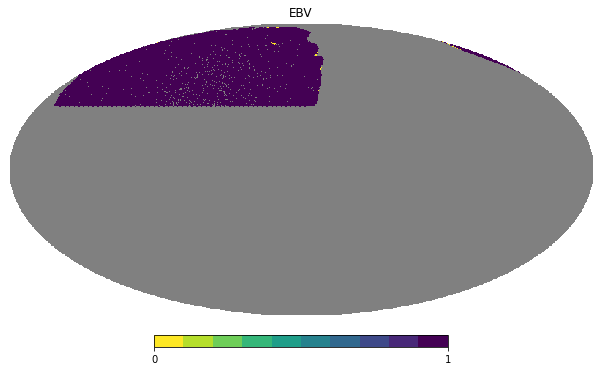

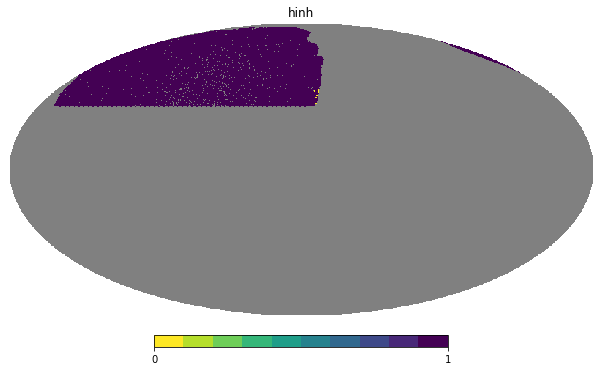

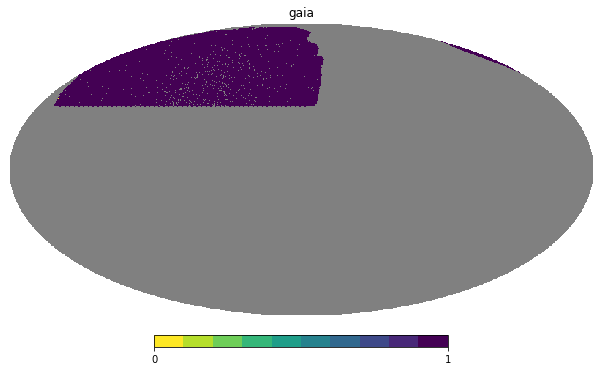

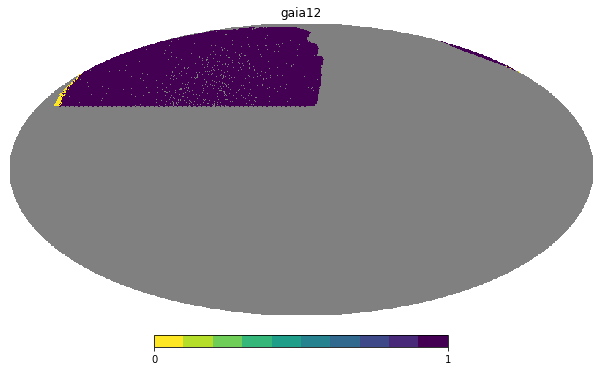

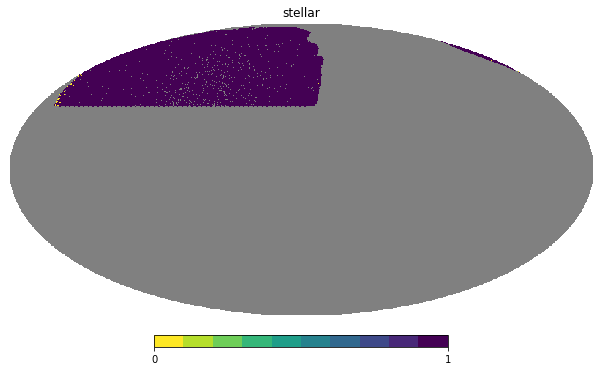

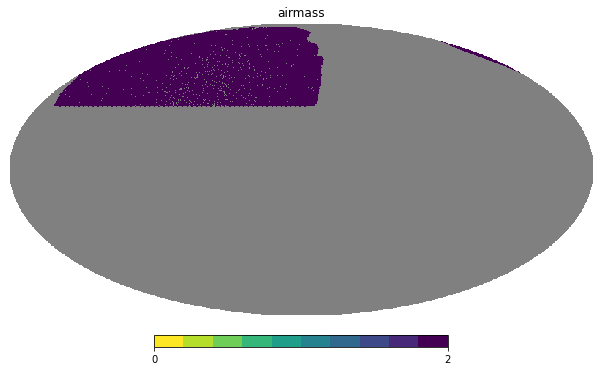

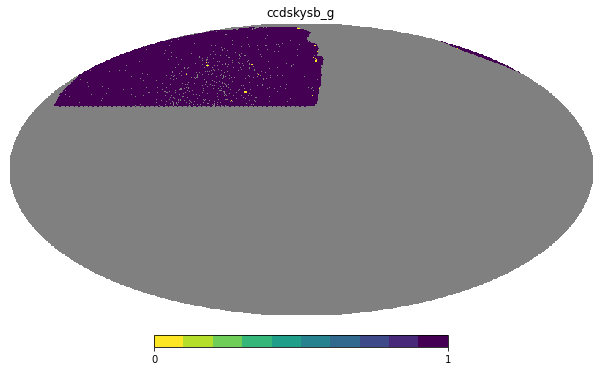

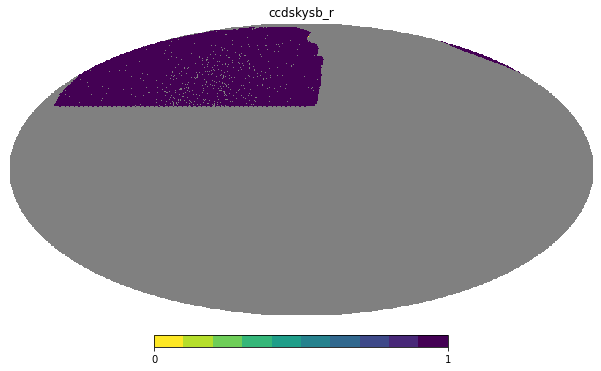

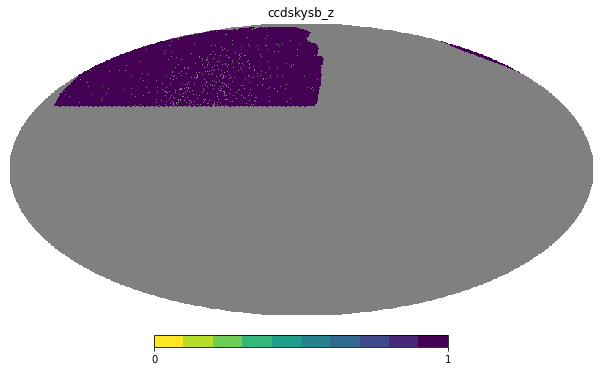

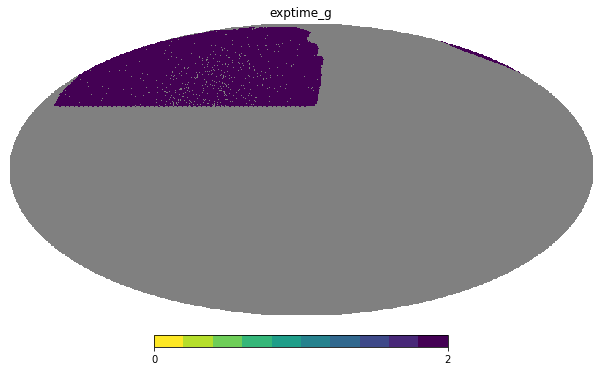

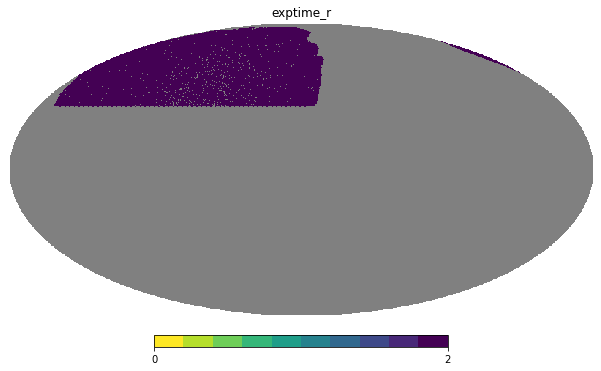

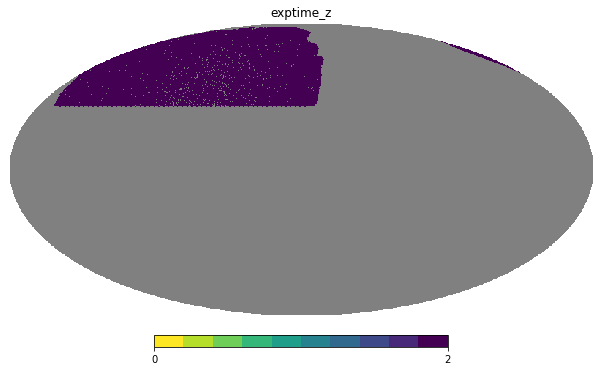

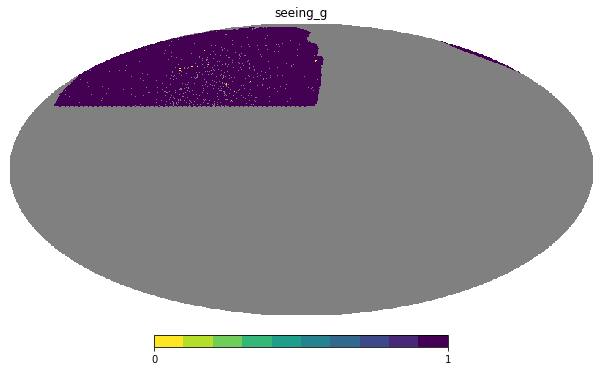

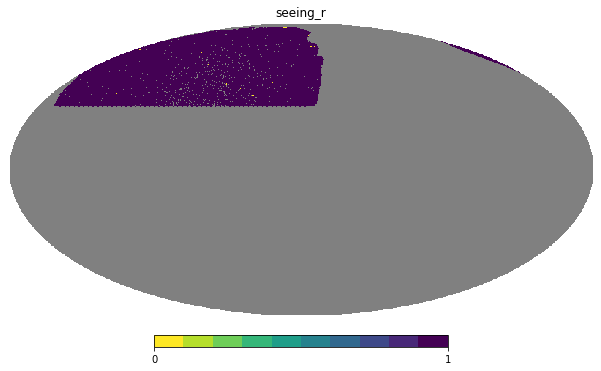

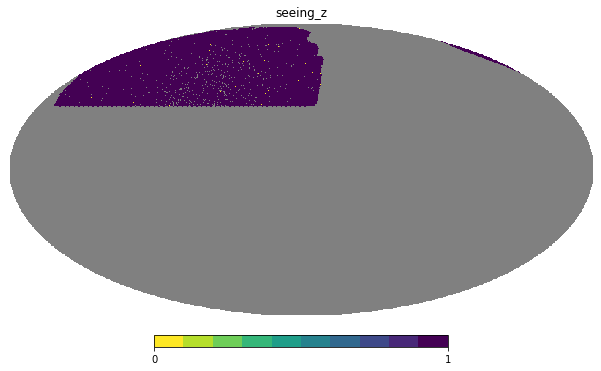

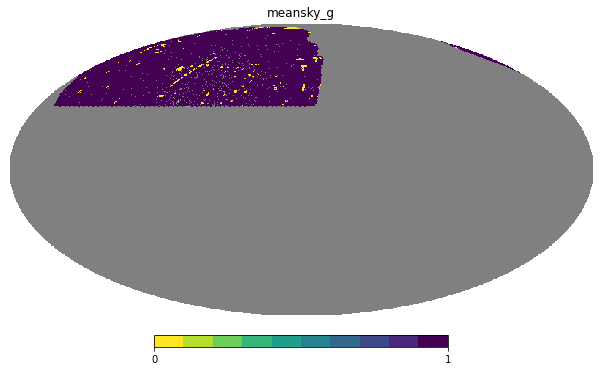

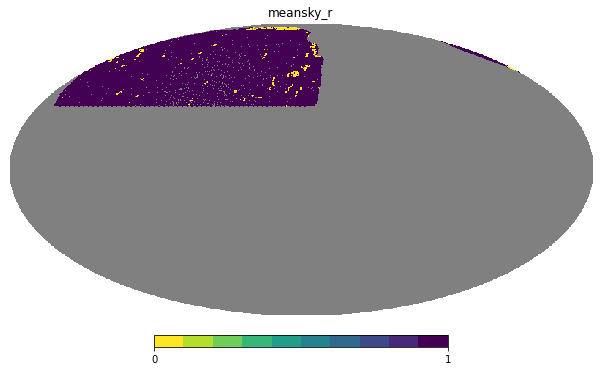

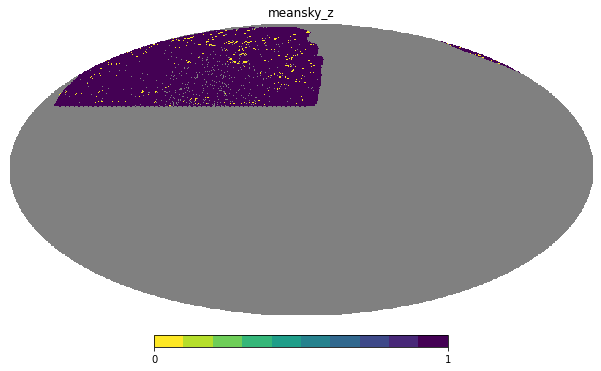

In [249]:
# repeat the loop over systematics but now show what pixels are being cut for each

hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN

for i, nm in enumerate(names):
    themin, themax = np.min(data[nm]), np.max(data[nm])
    ind = np.isfinite(data[nm])
    themean, thestd = np.median(data[nm][ind]), mad(data[nm][ind], scale='normal')
    themin2 = themean - x * thestd
    themax2 = themean + x * thestd
    ind &= data[nm] < themax2
    ind &= data[nm] > themin2
    if np.sum(ind) > 0:
        hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN
        hpmap[ipix[ind]] = 1
        hpmap[ipix[hpmap[ipix] == hp.UNSEEN]] = 0
        hp.mollview(hpmap, hold=False, cmap=cm.get_cmap('viridis_r', 10), norm='hist', rot=110, title=nm)